In [2]:
# activate package, basic imports + load data
# include("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/analysis_fixtures.jl")
# include("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/analysis_visuals.jl")

include("C:\\Users\\Federico\\Documents\\GitHub\\pysical_locomotion\\analysis\\behavior\\analysis_fixtures.jl")
include("C:\\Users\\Federico\\Documents\\GitHub\\pysical_locomotion\\analysis\\behavior\\analysis_visuals.jl")
using Dierckx

import jcontrol: State, movingaverage
import jcontrol: Track

@Info (Main):  Loaded 1021 trials 
  ╰──────────────────────────────────────────────── 
                      Tue, 24 May 2022 21:25:10 
@Info (Main):  After tortuosity analysis, discarded 9.109% of trials | 928 
  │                trials left 
  ╰──────────────────────────────────────────────── 
                      Tue, 24 May 2022 21:25:13 


  Activating project at `C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\behavior`


## Artificial dataset
Simple artificial dataset created from the global MTM solutions.

The solutoins are from multiple solutions: bikes with different parameters on different tracks.

## Load simulations

In [3]:
folder = "D:\\Dropbox (UCL)\\Rotation_vte\\Locomotion\\analysis\\RNN\\tracks_mtm_sims"
solutions, solnames = load_mtm_solutions(; folder=folder, name="")
@info "Loaded $(length(solutions)) solutions"

@Info (Main):  Loaded 237 solutions 
  ╰──────────────────────────────────────────────── 
                      Tue, 24 May 2022 21:25:35 


In [8]:
# get solutions for each track
tracks = map(n->split(n, "_")[1], solnames)
tracks_solutions = Dict(
    n=>map(x->x[2], filter(sn->sn[1]==n, collect(zip(tracks, solutions)))) for n in unique(tracks)
)
tracks_names = unique(tracks)



7-element Vector{SubString{String}}:
 "circle"
 "cosine"
 "double"
 "hairpin"
 "sine"
 "squiggle"
 "uturn"

In [12]:
# Load all the tracks
tracks_folder = "C:\\Users\\Federico\\Documents\\GitHub\\pysical_locomotion\\analysis\\RNN\\tracks"
tracks_files = glob("*.npy", tracks_folder)


tracks = Dict{String, Track}()
for tname in tracks_names
    file = filter(f->splitpath(f)[end] == "$(tname).npy", tracks_files)
    length(file) == 0 && continue
    tracks[tname] = Track(; npyfile=file[1], const_width=true, track_length=nothing)
end
tracks


Dict{String, Track} with 6 entries:
  "circle"   => Track. 305.0 cm long, 100001 waypoints.
  "sine"     => Track. 253.0 cm long, 100001 waypoints.
  "uturn"    => Track. 107.0 cm long, 100001 waypoints.
  "hairpin"  => Track. 268.0 cm long, 100001 waypoints.
  "cosine"   => Track. 259.0 cm long, 100001 waypoints.
  "squiggle" => Track. 522.0 cm long, 100001 waypoints.

### Inspect simulations

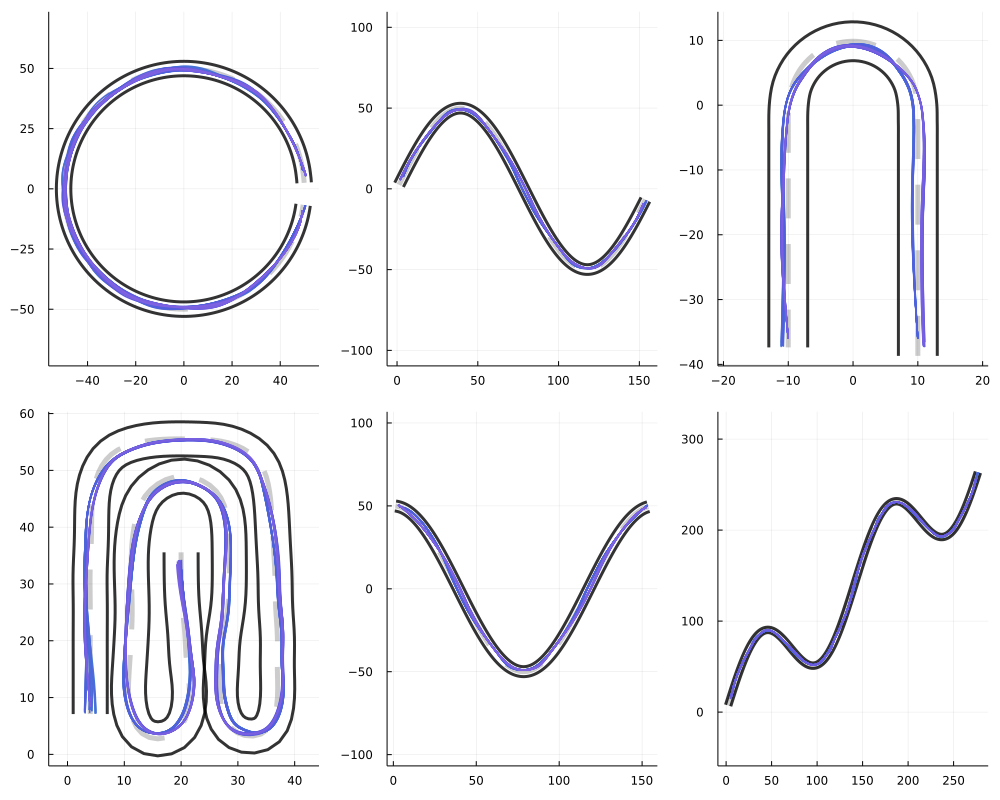

In [13]:
# plot solutions on each track
plots = []
colors = make_palette(100)

for (i, (trackname, track)) in enumerate(pairs(tracks))
    plt = plot(; aspect_ratio=:equal)
    draw!(track)
    for (n, sol) in enumerate(tracks_solutions[trackname])
        plot!(sol.x, sol.y, color=colors[n], lw=1.5, label=nothing)
    end
    push!(plots, plt)
end

plot(plots...; size=(1000, 800))

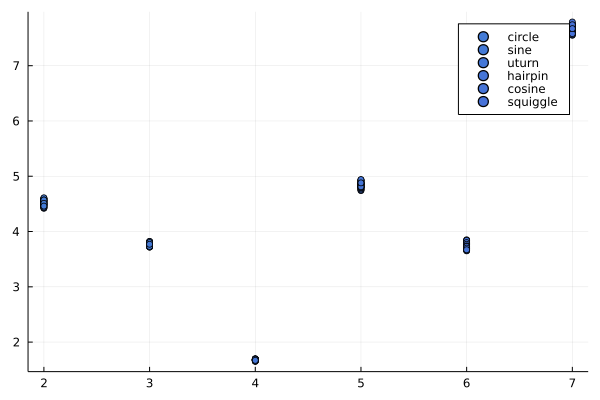

In [15]:
# plot durations for each track
plt = plot()
for (i, trackname) in enumerate(keys(tracks))

    durations = map(x->x.t[end], tracks_solutions[trackname])
    scatter!(ones(length(durations)).+i, durations, color=colors[i], label=trackname)
end
plt

@Info (Plots.#buildanimation#237):  Saved animation to  
  │ 
  │ (String)  ▶  fn = C:\Users\Federico\AppData\Local\Temp\jl_J3BDRBZnvr.gif 
  ╰──────────────────────────────────────────────── 
                      Tue, 24 May 2022 21:33:15 


Plots.AnimatedGif("C:\\Users\\Federico\\AppData\\Local\\Temp\\jl_J3BDRBZnvr.gif")
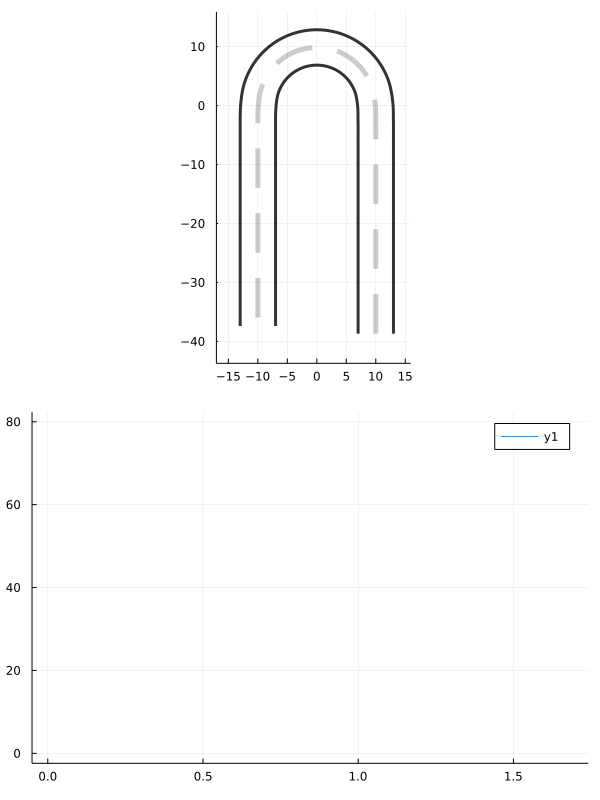

In [17]:
track_name = "uturn"
sol = tracks_solutions[track_name][1]
track = tracks[track_name]

xmin, xmax = min(sol.x...) - 5, max(sol.x...) + 5
ymin, ymax = min(sol.y...) - 5, max(sol.y...) + 5

anim = @animate for i in 1:length(sol.x)
    p1 = plot(sol.x[1:i], sol.y[1:i], color=:black, lw=1.5, label=nothing, aspect_ratio=:equal,
        xlim=[xmin, xmax], ylim=[ymin, ymax]
    )
    draw!(track)
    p2 = plot(sol.t[1:i], sol.u[1:i]; xlim=[0, sol.t[end]], ylim=[0, max(sol.u...)])
    plot(p1, p2; layout=[1, 1], size=(600, 800))
end every 5

gif(anim)

## Generate data

parameters

In [18]:
n_trials = 25  # number of "cuts" per simulation
N_samples_per_trial = 128 # number of samples per trial
Δs = 5  # distance between sampling's of the track's curvature
S = 50   # lookahead distance for track's curvature.

""" get random time steps from a solution """
time_stamps(solution) = rand(1:(length(solution.t)-N_samples_per_trial-1), n_trials)
nothing

get dataset entries

In [19]:
struct DatasetEntry
    n::Vector{Float64}
    ψ::Vector{Float64}
    s::Vector{Float64}
    V::Vector{Float64}
    ω::Vector{Float64}
    V̇::Vector{Float64}
    ω̇::Vector{Float64}
    k::Matrix{Float64}   # stores the curvature at each waypoint and each frame
end

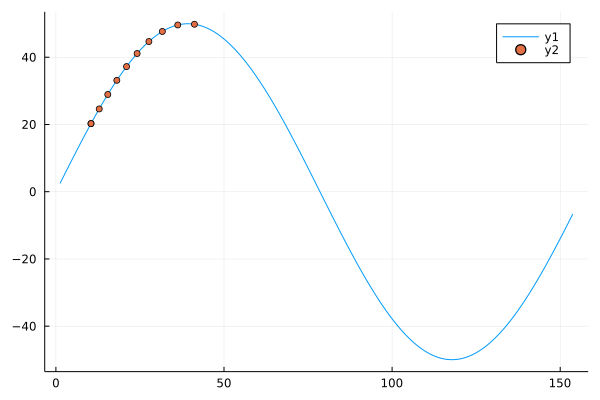

In [21]:
"""
Given an s-value, returns a set of indexes to access the track's variables at equally spaced
points along the track.

"""
function get_track_waypoints(track, sval)
    ds = track.S .- sval
    idxs = findall(
        (diff(mod.(ds, Δs)) .<= 0) .* (ds .>= 0)[2:end] .* (ds .<= S)[2:end],
    )
    return [argmin(ds.^2), idxs...]
end

# visually check that we can select waypoints along the track
track = tracks["sine"]
track_idxs = get_track_waypoints(track, 20)
plot(track.X, track.Y)
scatter!(track.X[track_idxs], track.Y[track_idxs]; aspect_ratio=:equal)

In [29]:
waypoints = collect(0:Δs:S)
waypoints_idxs = 1:length(waypoints)


entries = []
for (trackname, track) in pairs(tracks)
    @info "Processing $trackname"
    
    for solution in tracks_solutions[trackname]
        V = sqrt.(solution.v .^ 2 + solution.u .^ 2)
        V̇ = [0, diff(V)...]
        ω̇ = [0, diff(solution.ω)...]

        
        for ts in time_stamps(solution)
            if solution.s[ts + N_samples_per_trial] + S > 240
                continue
            end

            # get curvature
            curv = zeros(length(waypoints_idxs), N_samples_per_trial)


            for frame in 1:N_samples_per_trial
                    s = solution.s[ts + frame]
                    idxs = get_track_waypoints(track, s)

                    # @assert length(idxs) == length(waypoints_idxs)  "$(length(idxs)) $(length(waypoints_idxs)) $ts $frame $s"
                    length(idxs) != length(waypoints_idxs) && continue
                    curv[:, frame] = track.curvature[idxs]
            end

            push!(entries, DatasetEntry(
                    solution.n[ts:ts+N_samples_per_trial-1],
                    solution.ψ[ts:ts+N_samples_per_trial-1],
                    solution.s[ts:ts+N_samples_per_trial-1],
                    V[ts:ts+N_samples_per_trial-1],
                    solution.ω[ts:ts+N_samples_per_trial-1],
                    V̇[ts:ts+N_samples_per_trial-1],
                    ω̇[ts:ts+N_samples_per_trial-1],
                    curv,
                )
                )
        end
    end
end

@Info (Main.top-level scope):  Processing circle 
  ╰──────────────────────────────────────────────── 
                      Tue, 24 May 2022 22:22:46 
@Info (Main.top-level scope):  Processing sine 
  ╰──────────────────────────────────────────────── 
                      Tue, 24 May 2022 22:25:37 
@Info (Main.top-level scope):  Processing uturn 
  ╰──────────────────────────────────────────────── 
                      Tue, 24 May 2022 22:29:00 
@Info (Main.top-level scope):  Processing hairpin 
  ╰──────────────────────────────────────────────── 
                      Tue, 24 May 2022 22:34:04 
@Info (Main.top-level scope):  Processing cosine 
  ╰──────────────────────────────────────────────── 
                      Tue, 24 May 2022 22:37:18 
@Info (Main.top-level scope):  Processing squiggle 
  ╰──────────────────────────────────────────────── 
                      Tue, 24 May 2022 22:40:42 


#### Save data

In [30]:
@info "got $(length(entries)) entries"

@Info (Main):  got 3188 entries 
  ╰──────────────────────────────────────────────── 
                      Tue, 24 May 2022 23:00:23 


In [32]:
using JSON: JSON
using DataFrames: DataFrame
import JSONTables: objecttable, jsontable
import OrderedCollections: OrderedDict

savepath = "D:\\Dropbox (UCL)\\Rotation_vte\\Locomotion\\analysis\\RNN\\artificial_dataset"

for (i, entry) in enumerate(entries)
    ks = collect(Symbol("k_", i)=>entry.k[i, :] for i in 1:size(entry.k,1 ))
    dict = OrderedDict{Symbol, Union{Vector{Float64}, Matrix{Float64}}}(
        :n=>entry.n,
        :ψ=>entry.ψ,
        :s=>entry.s,
        :V=>entry.V,
        :ω=>entry.ω,
        :v̇=>entry.V̇,
        :ω̇=>entry.ω̇,
        ks...
    )
    df = DataFrame(dict)

    open(joinpath(savepath, "$(i).json"), "w") do f
        write(f, objecttable(df))
    end
end